In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.metrics import AUC, Accuracy 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     InputLayer,
                                     BatchNormalization,
                                     Dropout,
                                     Dot,
                                     Flatten)

## Load MNIST

In [9]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


<Figure size 640x480 with 0 Axes>

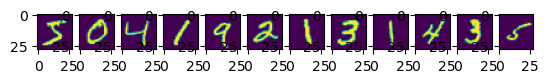

In [10]:
plt.figure()
fig, axs = plt.subplots(1, 12)
[axs[i].imshow(X_train[i]) for i in range(12)]
plt.show()

## Basic Keras Deep Net

In [11]:
model = Sequential()
model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(784, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(300, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

# model compile
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=opt, metrics=['Accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                       

### Train

In [12]:
model.fit(X_train, y_train, batch_size=64,  verbose=0, epochs=10,
          validation_data=(X_test, y_test))

In [13]:
_, acc = model.evaluate(X_test,
                        y_test,
                        batch_size=64,
                        verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))


Test accuracy: 98.1%


## LRP for keras models

Common propagation rules : 

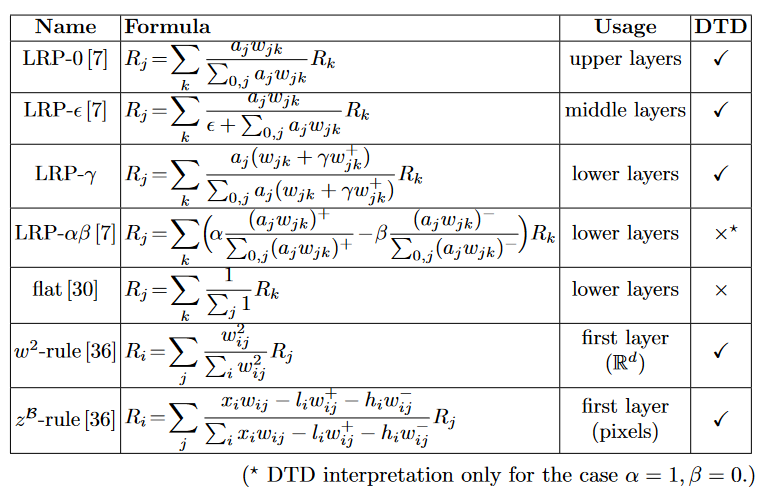

In [22]:
class My_LRP:
    def __init__(self, model, epsilon=None, gamma=None):
        self._layers = []
        for layer in model.layers:
            if isinstance(layer, Dense) or isinstance(layer, InputLayer) or isinstance(layer, Flatten):
                self._layers.append(layer)
        self._activations = {}
        self._R = {}
        
        self._epsilon = [0] * len(model.layers) if epsilon is None else epsilon
        self._gamma = [0] * len(model.layers) if gamma is None else gamma
            
    def _compute_activations(self, x):
        for layer in self._layers:
            if not isinstance(layer, InputLayer):
                out_fun = K.function([self._layers[0].input], [layer.output])
                layer_output = out_fun([x])[0]
                layer_output = tf.cast(layer_output, np.double)

                self._activations[layer.name] = layer_output
    
    def _compute_relevance(self, previous, current):
        w, b = previous.weights
        w = tf.cast(w, tf.double)
        b = tf.cast(b, tf.double)
        
        # helpers functions for epsilon and gamma rules 
        rho  = lambda w, l : w + self._epsilon[l] * np.maximum(0,w) # epsilon 
        incr = lambda z, l : z + self._gamma[l] * tf.reduce_mean(z**2)**.5+1e-9 # gamma 
       
        w = rho(w, self._layers.index(current))
        b = rho(b, self._layers.index(current))   
        
        z = incr(tf.matmul(self._activations[current.name], w) + b, self._layers.index(current))
        s = tf.divide(self._R[previous.name], z)
        c = tf.matmul(s, w, transpose_b=True)

        return self._activations[current.name] * c

    def explain(self, x):
        self._compute_activations(x)
        self._R[self._layers[-1].name] = self._activations[self._layers[-1].name]
        for previous, current in zip(reversed(self._layers), reversed(self._layers[:-1])):
            if not isinstance(previous, Flatten):
                self._R[current.name] = self._compute_relevance(previous, current)
        return self._R

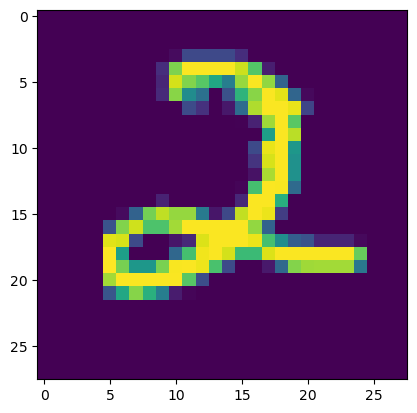

In [15]:
sample = np.expand_dims(X_test[np.random.randint(0, X_test.shape[0])], axis=0)
plt.imshow(np.squeeze(sample))

### No propagation rules (i.e gradient x input)

model predicted : 2


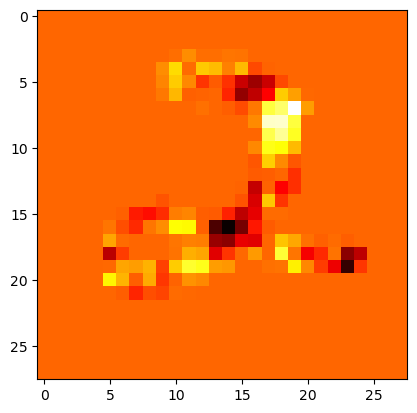

In [23]:
lrp = My_LRP(model)
R = lrp.explain(sample)
print(f'model predicted : {np.argmax(model(sample))}')
plt.imshow(R['flatten'].numpy().reshape(28, 28), cmap='hot')

### High epsilon : only the most salient factor are kept

model predicted : 2


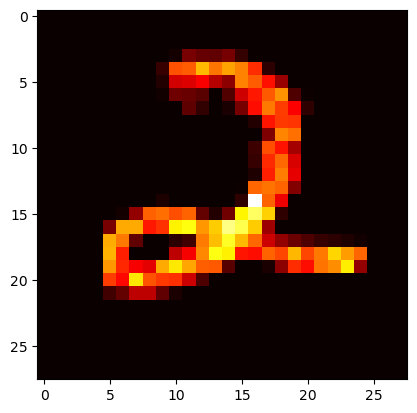

In [24]:
lrp = My_LRP(model, epsilon=[2,2,2,2,2])
R = lrp.explain(sample)
print(f'model predicted : {np.argmax(model(sample))}')
plt.imshow(R['flatten'].numpy().reshape(28, 28), cmap='hot')

### gamma 

model predicted : 2


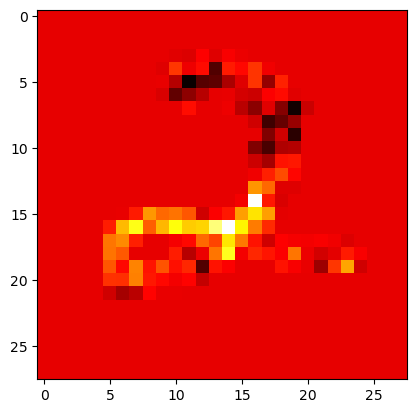

In [25]:
lrp = My_LRP(model, gamma=[2,2,2,2,2])
R = lrp.explain(sample)
print(f'model predicted : {np.argmax(model(sample))}')
plt.imshow(R['flatten'].numpy().reshape(28, 28), cmap='hot')

### epsilon & gamma applied according to layers location

model predicted : 2


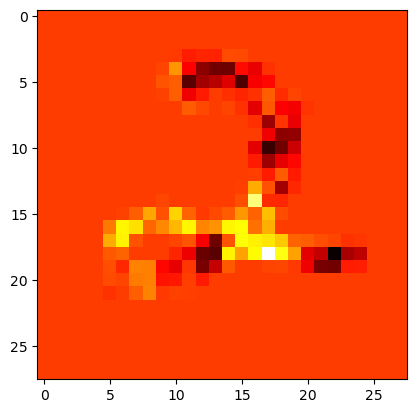

In [26]:
lrp = My_LRP(model, epsilon=[2,0,0,0,0], gamma=[0,2,0,0,0])
R = lrp.explain(sample)
print(f'model predicted : {np.argmax(model(sample))}')
plt.imshow(R['flatten'].numpy().reshape(28, 28), cmap='hot')

# Resources 
[Layer-Wise Relevance Propagation: An Overview](https://link.springer.com/chapter/10.1007/978-3-030-28954-6_10)

[LRP tutorial by Gregoire Montavon](https://git.tu-berlin.de/gmontavon/lrp-tutorial)
